In [1]:
%matplotlib inline
from IPython.display import HTML
from IPython.display import display, Markdown


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.linalg
import h5py
import ipywidgets as widgets

plt.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['figure.constrained_layout.use'] = True

# Greek alphabet: α, β, γ, δ, ε, ζ, η, θ, ι, κ, λ, μ, ν, ξ, ο, π, ρ, ς, σ, τ, υ, φ, χ, ψ, ω

# Constants
π = np.pi

In [261]:
# Functions
def open_file(filename, verbose):
    
    with h5py.File(filename, "r") as dataset:
        # Mixer frequency array
        fNCO_arr = np.asarray(dataset["mixer frequencies"])  # Hz
        # Pump amplitudes array 
        pamp_arr = np.asarray(dataset["signal amplitudes"])  # fsu

        # Data array
        spectrum_arr = np.zeros((len(pamp_arr), len(fNCO_arr), 61), dtype=complex)

        # Mixer frequency loop
        for fNCO_ind, fNCO_val in enumerate(fNCO_arr):

            if verbose:
                print("fNCO index", fNCO_ind)

            # Amplitude loop
            for amp_ind, amp_val in enumerate(pamp_arr):
                # Amplitude folder
                folder_amp = dataset['signal_amp_' + str(amp_val)]

                # Bandwidth of the measurement in Hz
                df = folder_amp['tuned df, Npix, mixerfreq'][0]
                # Number of pixels
                N_pix = folder_amp['tuned df, Npix, mixerfreq'][1]
                # Mixer frequency (center frequency of our comb) in Hz
                fNCO = fNCO_val

                # USB and LSB frequency combs
                comb_freqs_usb = folder_amp['frequency combs'][0][:-1]  # We remove the last column due to some mistake in the measurement
                comb_freqs_lsb = -np.flip(comb_freqs_usb[1:])           # We remove the first column because it is already in the USB
                # All frequencies in one array
                comb_freqs = np.concatenate((comb_freqs_lsb, comb_freqs_usb))

                # Raw USB and LSB output data from Vivace, we remove the same indices as for the frequency comb
                spectrum_usb = np.asarray(folder_amp['USB data'][fNCO_ind][:-1])
                spectrum_lsb = np.flip(np.asarray(folder_amp['LSB data'][fNCO_ind][1:-1]))
                # All spectrum in one array 
                spectrum = np.concatenate((spectrum_lsb, spectrum_usb))
                # Save output spectrum in fsu
                spectrum_arr[amp_ind, fNCO_ind] = spectrum
    
    return spectrum_arr, comb_freqs, fNCO_arr, pamp_arr


def recon_nonlinear(Field, Field_in, field, field_in, freqs, indices, order):
    # Angular frequency
    ω = 2*π * freqs
    
    # Create H-matrix
    col1 = (1.0j*ω*(Field/np.sqrt(gain) - Field_in/np.sqrt(att)))[indices]
    col2 = 1.0j*(Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    col3 = (Field/np.sqrt(gain) - Field_in/np.sqrt(att))[indices]
    
    # Merge columns
    H = np.vstack((col1, col2, col3))
    
    # Non-linear damping terms
    for exp_ind, exp_val in enumerate(order):
        col = np.fft.fft(np.abs((field/np.sqrt(gain) - field_in/np.sqrt(att))) ** exp_val * (field / np.sqrt(gain) - field_in / np.sqrt(att)))[indices] / len(field)
        H = np.vstack((H, col))
    
    # Making the matrix real instead of complex
    Hcos = np.real(H)
    Hsin = np.imag(H)
    H = np.hstack((Hcos, Hsin))
    
    # Normalize H for a more stable inversion
    Nm = np.diag(1. / np.max(np.abs(H), axis=1))
    H_norm = np.dot(Nm, H)  # normalized H-matrix
    
    # The drive vector, Q (from the Yasuda paper)
    Qcos = np.real(Field_in/np.sqrt(att))[indices]
    Qsin = np.imag(Field_in/np.sqrt(att))[indices]
    Qmat = np.hstack((Qcos, Qsin))
    
    # Solve system Q = H*p
    H_norm_inv = scipy.linalg.pinv(H_norm)
    p_norm = np.dot(Qmat, H_norm_inv)
    
    # Re-normalize p-values
    # Note: we have actually solved Q = H * Nm * Ninv * p
    # Thus we obtained Ninv*p and multiply by Nm to obtain p
    p = np.dot(Nm, p_norm)  # re-normalize parameter values
    
    # Forward calculation to check result, should be almost everything zero vector
    Q_fit = np.dot(p, H)
    
    # Scale parameters by drive force assuming known resonant frequency
    param_recon = p
    
    # Parameters reconstructed
    lambda_recon = 1 / param_recon[0]
    fr_recon = lambda_recon * param_recon[1] / (2*π)
    kappa_arr = lambda_recon * param_recon[2:]
    
    return lambda_recon, fr_recon, kappa_arr, Q_fit


def dB(data):
    return 20 * np.log10(np.abs(data))


def dBm_out(data):
    return 16.612 * np.log10(np.abs(data)) - 16.743


def dBm_in(data):
    return 19.988 * np.log10(np.abs(data)) + 39.6


def W(data_dBm):
    return 10 ** ((data_dBm - 30) / 10)


def plot_2Dspectra(spectrum, freq_comb, freq_detuning, pow_arr, pow_ind, figure, axis):  
    cutoff = 0.01  # %
    zmin = np.percentile(spectrum, cutoff)
    zmax = np.percentile(spectrum, 100. - cutoff)

    a = axis.pcolormesh(freq_comb,
                        freq_detuning / 1e3,
                        spectrum[pow_ind,:,:],
                        cmap='RdBu_r',
                        vmin=zmin,
                        vmax=zmax,                   
                       )
    axis.set_ylabel('Comb center detuning (kHz)')
    axis.set_xlabel('Comb frequencies (Hz)')
    

def plot_power(spectrum, pow_arr, fNCO_ind_, axis):
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, 30], '.-', label='drive 1')
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, 32], '.-', label='drive 2')
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, 34], '.-', label='3rd order')
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, 36], '.-', label='5rd order')
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, 38], '.-', label='7rd order')
    axis.plot(pow_arr, spectrum[:, fNCO_ind_, -1], '.-', label='Background')

In [262]:
# Load raw data
verbose = False

# Load file
file_A = r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_200amps_11points.hdf5'
file_B = r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_10amps_201points.hdf5'
file_C = r'D:\TLS\TLS-Data\TLS_IMP_amped_DCAW23_3amps_detuned700kHz.hdf5'

# EXPERIMENTAL PARAMETERS
# Resonance frequency of the system
f_res = 4.1105253e9  # Hz
ω_res = 2 * π * f_res

# Gain of the output line
gain = 80.5  # dB
gain_lin = 10 ** (gain / 10)

# Attenuation of the input line
att = 68.9  # dB
att_lin = 10 ** (att / 10)

# Load raw data
spectrum_A, comb_freqs_A, fNCO_A, pamp_A = open_file(file_A, verbose)
spectrum_B, comb_freqs_B, fNCO_B, pamp_B = open_file(file_B, verbose)
spectrum_det, comb_freqs_det, fNCO_det, pamp_det = open_file(file_C, verbose)

# Comb center detuning
center_detuning_A = fNCO_A - f_res
center_detuning_B = fNCO_B - f_res
center_detuning_det = fNCO_det - f_res

In [263]:
def plot_2Dspectradet_sweep(pamp_ind_):
    figure, axis = plt.subplots(1)
    plot_2Dspectra(dB(spectrum_det), comb_freqs_det, center_detuning_det, dB(pamp_det), pamp_ind_, figure, axis)
    figure.colorbar(a, label='Signal magnitude [dBFS]')
    axis.set_title(r'|$A_{in}$|' + f' = {dB(pamp_det)[pamp_ind_]:.3f} [dBFS]')

# Interactive layout  
widgets.interact(plot_2Dspectradet_sweep,
                 pamp_ind_=widgets.IntSlider(min=0,
                                             max=len(pamp_det)-1,
                                             step=1,
                                             description='amp_ind',
                                             )
                )

plt.show()

def plot_2DspectraA_sweep(pamp_ind_):
    figure, axis = plt.subplots(1)
    plot_2Dspectra(dB(spectrum_A), comb_freqs_A, center_detuning_A, dB(pamp_A), pamp_ind_, figure, axis)
    figure.colorbar(a, label='Signal magnitude [dBFS]')
    axis.set_title(r'|$A_{in}$|' + f' = {dB(pamp_A)[pamp_ind_]:.3f} [dBFS]')

# Interactive layout  
widgets.interact(plot_2DspectraA_sweep,
                 pamp_ind_=widgets.IntSlider(min=0,
                                             max=len(pamp_A)-1,
                                             step=1,
                                             description='amp_ind',
                                             )
                )

plt.show()

def plot_2DspectraB_sweep(pamp_ind_):
    figure, axis = plt.subplots(1)
    plot_2Dspectra(dB(spectrum_B), comb_freqs_B, center_detuning_B, dB(pamp_B), pamp_ind_, figure, axis)
    figure.colorbar(a, label='Signal magnitude [dBFS]')
    axis.set_title(r'|$A_{in}$|' + f' = {dB(pamp_A)[pamp_ind_]:.3f} [dBFS]')

# Interactive layout  
widgets.interact(plot_2DspectraB_sweep,
                 pamp_ind_=widgets.IntSlider(min=0,
                                             max=len(pamp_B)-1,
                                             step=1,
                                             description='amp_ind',
                                             )
                )

plt.show()

interactive(children=(IntSlider(value=0, description='amp_ind', max=2), Output()), _dom_classes=('widget-inter…

interactive(children=(IntSlider(value=0, description='amp_ind', max=199), Output()), _dom_classes=('widget-int…

interactive(children=(IntSlider(value=0, description='amp_ind', max=11), Output()), _dom_classes=('widget-inte…

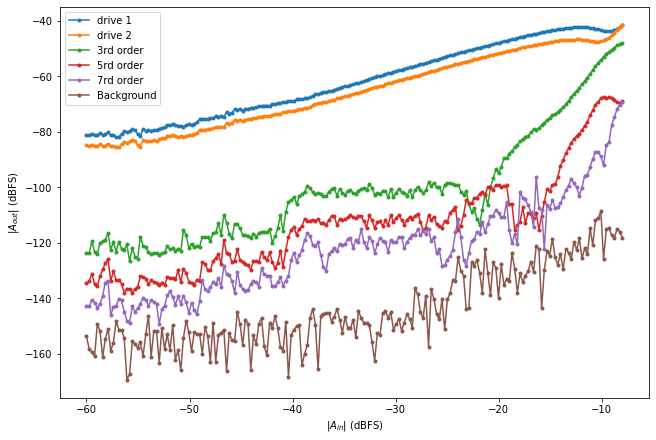

In [266]:
fNCO_ind_A = 6

# IMP vs output power
fig, ax = plt.subplots(1, figsize=(9,6))
plot_power(dB(spectrum_A), dB(pamp_A), fNCO_ind_A, ax)
ax.set_xlabel(r'|$A_{in}$| (dBFS)')
ax.set_ylabel('|$A_{out}$| (dBFS)')
ax.legend(loc='upper left')
plt.show()

In [71]:
# Experimental spectrum at a given power and mixer frequency
fig, ax = plt.subplots(2, figsize=(9,6))
def plot_spectrum(frequency, s)
ax[0].semilogy((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.abs(spectrum_arr[fNCO_ind, amp_ind, :]))
ax[1].plot((comb_freqs + fNCO_arr[fNCO_ind]) / 1e9, np.angle(spectrum_arr[fNCO_ind, amp_ind, :]))
ax[0].set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax[0].set_ylabel('|a| [fsu]')
ax[1].set_ylabel('$\mathcal{L} a $ [rad]')
ax[1].set_xlabel('frequency [GHz]')
plt.show()

SyntaxError: invalid syntax (<ipython-input-71-3bd18a8085fd>, line 3)

In [ ]:
# Spectrum at a given power and mixer frequency in dBm
fig, ax = plt.subplots(1)
ax.plot((comb_freqs+fNCO_arr[fNCO_ind])/1e9, dBm(np.abs(spectrum_arr[fNCO_ind, amp_ind, :])))
ax.set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax.set_ylabel('|$a_{out}$| [dBm]')
ax.set_xlabel('frequency [GHz]')

# Input field in the resonator
pamp_intracavity_dBm = pamp_dBm_arr - att
pamp_intracavity_W = W(pamp_intracavity_dBm)

# Output field in the resonator
spectrum_intracavity_dBm = dBm(np.abs(spectrum_arr)) - gain
spectrum_intracavity_W = W(spectrum_intracavity_dBm)

# Intra-cavity spectrum at a given power and mixer frequency in dBm
fig, ax = plt.subplots(1)
ax.plot((comb_freqs+fNCO_arr[fNCO_ind])/1e9, spectrum_intracavity_dBm[fNCO_ind, amp_ind, :])
ax.set_title(r'|$A_{in}$|' + f' = {pamp_dBm_arr[amp_ind]:.3f} dBm')
ax.set_ylabel('|a| [dBm]')
ax.set_xlabel('frequency [GHz]')
plt.show()

In [ ]:
# %% Reconstruction

# Out field in frequency and time domain (check this!)
Aout = spectrum_arr[fNCO_ind, amp_ind, :]
aout = np.fft.ifft(Aout)
aout *= len(aout)

# Drive or input field in frequency and time domain
ind_drive = np.array([30, 32])
Ain = np.zeros_like(Aout, dtype=np.complex)
Ain[ind_drive] = pamp_arr[amp_ind]
ain = np.fft.ifft(Ain)
ain *= len(ain)

# Intermodulation product indices
nimps = 28
ind_imp = np.arange(ind_drive[0]-nimps, ind_drive[1]+nimps+2, 2)

# Reconstruction order
order_val = 9
recon_order = np.arange(2, order_val, 2)

fig2, ax = plt.subplots(1)
ax.semilogy(comb_freqs, np.abs(Aout), label='$A_{out}$')
ax.semilogy(comb_freqs, np.abs(Ain), '-.', label='$A_{in}$')
ax.semilogy(comb_freqs[ind_imp], np.abs(Aout[ind_imp]), '.', label='$A_{in}$')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('|a|')
fig2.legend(frameon=False)
plt.show()

λ_recon, f0_recon, κ_recon, Qmat_fit = recon_nonlinear(Field=Aout,
                                                       Field_in=Ain,
                                                       field=aout,
                                                       field_in=ain,
                                                       freqs=comb_freqs,
                                                       indices=ind_imp,
                                                       order=recon_order,
                                                      )
λ_recon = complex(np.sqrt(complex(λ_recon)))

# Print results
print('\033[1m' + 'RECONSTRUCTED PARAMETERS')
print('{:<15} {:<15}'.format('Parameter','Value') + '\033[0m')
print('{:<15} {:<15}'.format('f0_recon', f'{f0_recon:.5f} Hz'))
print('{:<15} {:<15}'.format('λ_recon', f'{λ_recon:.5f}'))
print('{:<15} {:<15}'.format('κ1_recon', f'{κ_recon[0]:.3e}'))
for order_ind, order_val in enumerate(recon_order):
    print('{:<15} {:<15}'.format(f'κ{order_val+1}_recon', f'{κ_recon[order_ind+1]:.3e}'))